# Training the SPOCK model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
    plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
    pass

In [37]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
    solar_system_synthetic_theory=pickle.load(fi)

In [39]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
    solar_system_synthetic_theory.masses,
    solar_system_synthetic_theory.semi_major_axes,
    solar_system_synthetic_theory.omega_vector,
    [truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
    [truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [48]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])
df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


evectors, ivectors
relative to the planet
add variance of a, res osc will shift sec

In [49]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [43]:
integration_path = Path("integrations/ecc_inc_integrations")
file_names = list(integration_path.glob("*.npz"))
rows = []

for i in range(len(file_names)):
    soln_h = np.load(file_names[i])
    y = soln_h["arr_1"]
    prope_value = np.average(np.abs((y[9] - 1j * y[0]) / np.sqrt(2)))
    propsini_value = np.average(np.abs((y[1+9] - 1j * y[1]) / np.sqrt(2)))
    des_n = file_names[i].stem.replace("integration_results_", "")
    rows.append([des_n, prope_value, propsini_value])

df_h = pd.DataFrame(rows, columns=["Des'n", "prope_h", "propsini_h"])

In [50]:
merged_full_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_full_df = pd.merge(merged_full_df, df_h, on="Des'n", how="inner")
merged_full_df.shape, labels.shape

((103203, 23), (1249051, 11))

In [45]:
merged_full_df[(merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope']>1]

,Des'n,H_x,G,Epoch,M,Peri.,Node,Incl.,e,n,...,prope,de,propsini,dsini,g,s,H_y,NumOpps,prope_h,propsini_h
39,00040,6.55,0.15,K239D,210.11613,269.07148,94.15865,4.25553,0.046210,.28864981,...,0.020955,0.000190,0.065183,0.000031,34.768528,-35.198622,6.55,78,0.053852,0.079179
71,00072,9.11,0.15,K239D,108.80870,103.00771,207.93446,5.41847,0.121318,.28890519,...,0.073572,0.000270,0.103208,0.000250,33.893666,-35.556858,9.11,66,0.165236,0.113096
86,00087,6.96,0.15,K239D,334.81925,264.40300,73.01222,10.88030,0.093892,.15201625,...,0.054077,0.000020,0.170895,0.000002,134.875041,-130.862018,6.96,77,0.112878,0.190548
109,00110,7.91,0.15,K239D,197.01120,282.23632,56.77086,5.95987,0.079730,.21814725,...,0.045066,0.001500,0.089019,0.000730,58.119053,-56.297173,7.91,71,0.097941,0.099361
135,00136,9.80,0.15,K239D,313.08930,132.72752,186.40219,9.58067,0.084394,.28500582,...,0.018432,0.000250,0.173369,0.000099,31.891828,-34.818274,9.80,60,0.146849,0.187487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102876,V3403,16.56,0.15,K239D,339.20801,69.68596,322.23340,28.51445,0.353584,.23643691,...,0.101220,0.000220,0.515434,0.000031,-85.789058,-40.766004,16.56,8,0.240309,0.519341
102886,V3413,15.02,0.15,K239D,85.62071,185.36044,144.78670,15.79305,0.068230,.15292036,...,0.055624,0.000016,0.256620,0.000002,93.876576,-108.551864,15.02,16,0.113228,0.267623
102890,V3417,16.71,0.15,K239D,165.81302,346.20504,288.86443,8.63358,0.033266,.25074798,...,0.028305,0.000340,0.162822,0.000091,60.060826,-41.560554,16.71,15,0.084491,0.146521
102963,V3490,17.20,0.15,K239D,125.52778,178.48806,111.35308,14.19852,0.066047,.23823714,...,0.060429,0.000024,0.229592,0.000001,40.556315,-44.623785,17.20,11,0.127651,0.248967


(0.0, 10.0)

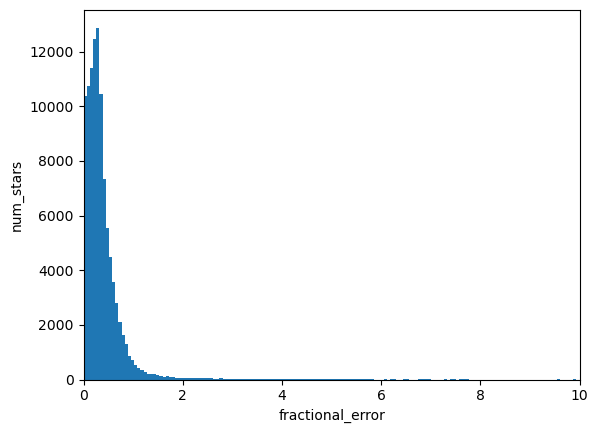

In [51]:
fractional_error = np.abs((merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope'])

plt.hist(fractional_error, bins = 1000)
plt.xlabel("fractional_error")
plt.ylabel("num_stars")
plt.xlim(0, 10)

In [52]:
merged_df_low = merged_full_df[(merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope'] < 1]
merged_df_low

,Des'n,H_x,G,Epoch,M,Peri.,Node,Incl.,e,n,...,prope,de,propsini,dsini,g,s,H_y,NumOpps,prope_h,propsini_h
0,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,...,0.115193,0.000160,0.167560,0.000013,54.253800,-59.249995,3.34,123,0.079964,0.184069
1,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,...,0.280234,0.000340,0.546016,0.000045,-1.372312,-46.451120,4.12,121,0.285013,0.547257
2,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,...,0.233600,0.000010,0.229144,0.000003,43.858531,-61.476025,5.17,114,0.191032,0.243108
3,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,...,0.099452,0.000140,0.111023,0.000180,36.882605,-39.610314,3.22,110,0.145956,0.127379
4,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,...,0.171249,0.012000,0.076113,0.001400,52.506470,-51.132322,7.00,87,0.170989,0.098024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103198,V3731,17.30,0.15,K239D,69.30959,48.17590,39.72194,3.03599,0.151238,.26275482,...,0.161314,0.000033,0.044515,0.000015,40.857514,-45.215947,17.30,14,0.106017,0.041739
103199,V3732,17.00,0.15,K239D,192.24129,84.40086,255.40404,0.74267,0.202753,.26925042,...,0.164481,0.000110,0.030835,0.000082,39.449273,-43.638389,17.00,13,0.210316,0.020970
103200,V3733,17.50,0.15,K239D,68.58415,52.83351,18.32306,2.09487,0.165748,.26069574,...,0.163223,0.000044,0.035626,0.000022,41.628733,-46.031466,17.50,10,0.113113,0.023005
103201,V3734,16.63,0.15,K239D,118.36774,292.08682,101.80963,3.45118,0.188164,.26436356,...,0.163125,0.000240,0.044723,0.000011,40.467054,-44.880864,16.63,13,0.153652,0.065427


In [86]:
merged_df_high = merged_full_df[np.abs((merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope'])>0.5]
merged_df_high

,Des'n,H_x,G,Epoch,M,Peri.,Node,Incl.,e,n,...,prope,de,propsini,dsini,g,s,H_y,NumOpps,prope_h,propsini_h
5,00006,5.61,0.15,K239D,144.00279,239.58573,138.63642,14.73599,0.202669,.26089808,...,0.158950,0.000130,0.249017,0.000520,31.540156,-41.819571,5.61,103,0.255600,0.269695
7,00008,6.61,0.15,K239D,317.28634,285.60293,110.86315,5.88917,0.156501,.30180081,...,0.144783,0.000120,0.096433,0.000170,32.049097,-35.508300,6.61,94,0.070661,0.112412
10,00011,6.73,0.15,K239D,329.09194,195.82238,125.51744,4.63154,0.099322,.25659806,...,0.074519,0.000022,0.067789,0.000015,40.764583,-43.166575,6.73,105,0.128441,0.088312
38,00039,5.97,0.15,K239D,283.01826,209.81255,156.93080,10.37052,0.111983,.21393115,...,0.069381,0.000047,0.170392,0.000017,53.886490,-56.663092,5.97,91,0.107808,0.187571
39,00040,6.55,0.15,K239D,210.11613,269.07148,94.15865,4.25553,0.046210,.28864981,...,0.020955,0.000190,0.065183,0.000031,34.768528,-35.198622,6.55,78,0.053852,0.079179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103162,V3695,17.91,0.15,K239D,253.68596,138.02570,218.18840,21.02458,0.077818,.37771119,...,0.060856,0.001500,0.372089,0.000320,13.711445,-21.315198,17.91,10,0.096225,0.346116
103172,V3705,16.06,0.15,K239D,262.34097,131.35894,193.69112,20.34015,0.011321,.17760588,...,0.046602,0.004800,0.351123,0.000014,52.609142,-60.292317,16.06,13,0.079098,0.355179
103175,V3708,16.79,0.15,K239D,228.19931,199.49483,148.51466,11.42701,0.155650,.27427365,...,0.103601,0.000097,0.189143,0.000013,32.889364,-37.940232,16.79,12,0.165651,0.206787
103182,V3715,17.11,0.15,K239D,130.63233,295.93257,130.67223,7.47535,0.087368,.26914316,...,0.092559,0.000120,0.122260,0.000095,36.919556,-39.810900,17.11,13,0.030123,0.142963


In [87]:
import numpy as np
from itertools import product, combinations_with_replacement

asteroids_g = merged_df_high['g'].tolist()
asteroids_a = merged_df_high['a'].tolist()
diff = 0.5
percentage = 0.5
multiples = list(range(-3, 4))

def k_vec_generation(max_order = 3, size = 7):
    kvecs = []
    
    for order in range(1, max_order + 1):
        for positions in combinations_with_replacement(range(size), order):
            for variables in combinations_with_replacement([-1, 1], order):
                k = np.zeros(size, dtype = int)
                for i, n in zip(positions, variables):
                    k[i] += n
                kvecs.append(k)
    kvecs = np.array(kvecs)
    indices = np.where((kvecs == np.zeros(size)).all(axis = 1))
    kvecs = np.delete(kvecs, indices, axis=0)
    return kvecs

use_k_vecs = False
resonances = []

for i in range(len(asteroids_g)):
    a_ast = asteroids_a[i]
    g_ast = asteroids_g[i]
    tp_h = TestParticleSecularHamiltonian(asteroids_a[i],simpler_secular_theory)
    sorted_solutions = sorted(tp_h.F_e.items(), key=lambda item: np.abs(item[1]), reverse=True)
    planets_g = []
    for m, amp in sorted_solutions:
        freq = np.dot(m, solar_system_synthetic_theory.omega_vector)
        planets_g.append(freq)
    k_vecs = k_vec_generation(max_order = 3, size = len(planets_g))
    found_resonance = False
    for k in k_vecs:
        resonance_combo = np.dot(k, planets_g)
        if np.abs((g_ast - resonance_combo)/g_ast) < percentage:
            print(f"Asteroid {i} is in resonance: g_ast = {g_ast:.6f}, "
                  f"k · g_planets = {resonance_combo:.6f}, k = {k}")
            found_resonance = True
            resonances.append([i, g_ast, resonance_combo, k])
            break

    if not found_resonance:
        print(f"Asteroid {i} not in resonance.")



Asteroid 0 not in resonance.
Asteroid 1 not in resonance.
Asteroid 2 not in resonance.
Asteroid 3 not in resonance.
Asteroid 4 not in resonance.
Asteroid 5 not in resonance.
Asteroid 6 not in resonance.
Asteroid 7 not in resonance.
Asteroid 8 not in resonance.
Asteroid 9 not in resonance.
Asteroid 10 not in resonance.
Asteroid 11 not in resonance.
Asteroid 12 not in resonance.
Asteroid 13 not in resonance.
Asteroid 14 not in resonance.
Asteroid 15 not in resonance.
Asteroid 16 not in resonance.
Asteroid 17 not in resonance.
Asteroid 18 not in resonance.
Asteroid 19 not in resonance.
Asteroid 20 not in resonance.
Asteroid 21 not in resonance.
Asteroid 22 not in resonance.
Asteroid 23 not in resonance.
Asteroid 24 not in resonance.
Asteroid 25 not in resonance.
Asteroid 26 not in resonance.
Asteroid 27 not in resonance.
Asteroid 28 not in resonance.
Asteroid 29 not in resonance.
Asteroid 30 not in resonance.
Asteroid 31 not in resonance.
Asteroid 32 not in resonance.
Asteroid 33 not in r

KeyboardInterrupt: 

In [88]:
merged_df = merged_df_high

In [89]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])

/tmp/ipykernel_269588/3737764660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])


In [90]:
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

/tmp/ipykernel_269588/2614236503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
/tmp/ipykernel_269588/2614236503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
/tmp/ipykernel_269588/2614236503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [ ]:
merged_df.to_csv("integrations/merged_elements.csv")

In [23]:
merged_df = pd.read_csv("integrations/merged_elements.csv")
merged_df.columns

/tmp/ipykernel_269588/2756484719.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("integrations/merged_elements.csv")


Index(['Unnamed: 0', 'Des'n', 'H_x', 'G', 'Epoch', 'M', 'Peri.', 'Node',
       'Incl.', 'e', 'n', 'a', 'propa', 'da', 'prope', 'de', 'propsini',
       'dsini', 'g', 's', 'H_y', 'NumOpps', 'prope_h', 'propsini_h', 'g0',
       'ecospo', 'esinpo', 'sinicosO', 'sinisinO'],
      dtype='object')

In [91]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0']
data = merged_df[features]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['prope_h']
delsini = merged_df['propsini_h']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

In [92]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)

In [93]:
trainY.shape

(18171,)

In [94]:
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [95]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBRegressor(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-rmse-mean"])
    error = np.mean(score["test-rmse-std"])
    
    print("SCORE:", avg_score, "+/-", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [96]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.05128290719037698                                   
+/-                                                   
0.008244694751526265                                  
SCORE:                                                                         
0.051388321072881146                                                           
+/-                                                                            
0.008026818373046102                                                           
SCORE:                                                                          
0.05211674249772846                                                             
+/-                                                                             
0.010284878038779494                                                            
SCORE:                                                                          
0.05092868731354314                                    

In [97]:
best

{'x_max_depth': 6.0,
 'x_min_child': 29.027212358902943,
 'x_subsample': 0.9458899808537233}

In [98]:
model = XGBRegressor(learning_rate = 0.05, 
                         max_depth = 6, 
                         subsample = 0.946,
                         min_child_weight = 29.03)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", verbose_eval=True, num_boost_round=500)

[0]	train-rmse:0.08481+0.00165	test-rmse:0.08459+0.00678
[1]	train-rmse:0.08166+0.00170	test-rmse:0.08145+0.00705
[1]	train-rmse:0.08166+0.00170	test-rmse:0.08145+0.00705
[2]	train-rmse:0.07864+0.00172	test-rmse:0.07847+0.00736
[3]	train-rmse:0.07575+0.00173	test-rmse:0.07556+0.00769
[4]	train-rmse:0.07303+0.00174	test-rmse:0.07282+0.00799
[5]	train-rmse:0.07051+0.00172	test-rmse:0.07032+0.00836
[6]	train-rmse:0.06809+0.00177	test-rmse:0.06791+0.00859
[7]	train-rmse:0.06583+0.00184	test-rmse:0.06561+0.00884
[8]	train-rmse:0.06376+0.00184	test-rmse:0.06355+0.00915
[9]	train-rmse:0.06180+0.00193	test-rmse:0.06158+0.00936
[10]	train-rmse:0.05989+0.00196	test-rmse:0.05965+0.00962
[11]	train-rmse:0.05812+0.00200	test-rmse:0.05784+0.00989
[12]	train-rmse:0.05647+0.00201	test-rmse:0.05619+0.01014
[13]	train-rmse:0.05490+0.00205	test-rmse:0.05462+0.01037
[14]	train-rmse:0.05345+0.00209	test-rmse:0.05313+0.01059
[15]	train-rmse:0.05211+0.00214	test-rmse:0.05180+0.01077
[16]	train-rmse:0.05085+0

# n_estimators (number of trees) tuning

Text(0, 0.5, 'CV AUC score')

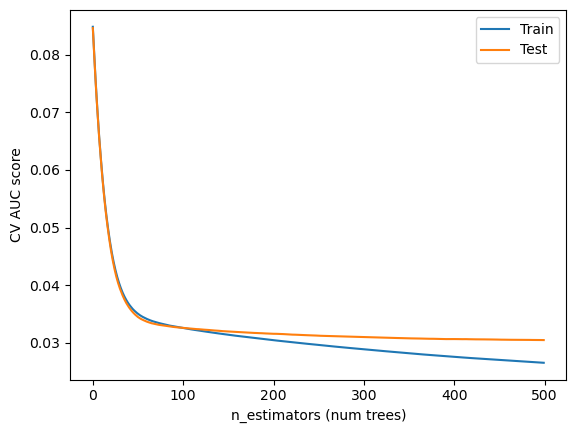

In [99]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

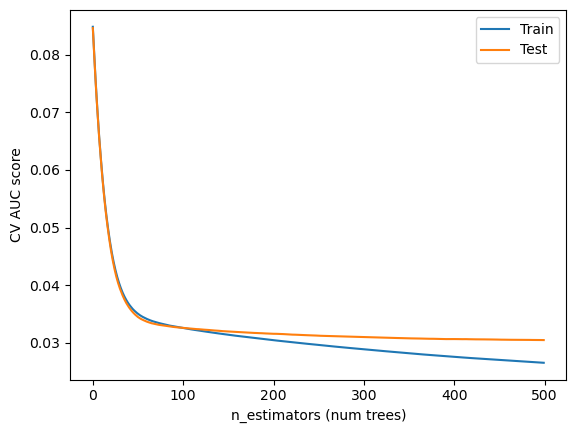

In [100]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

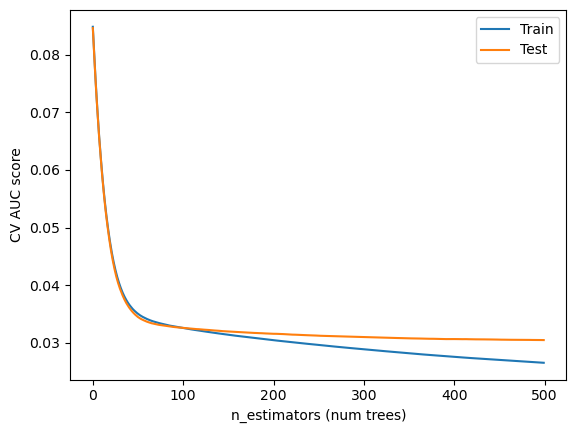

In [101]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

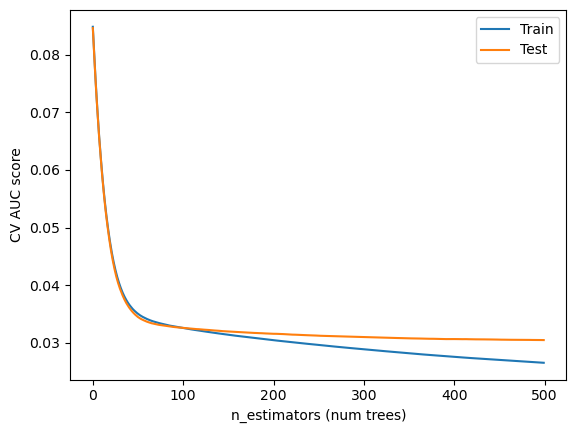

In [102]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

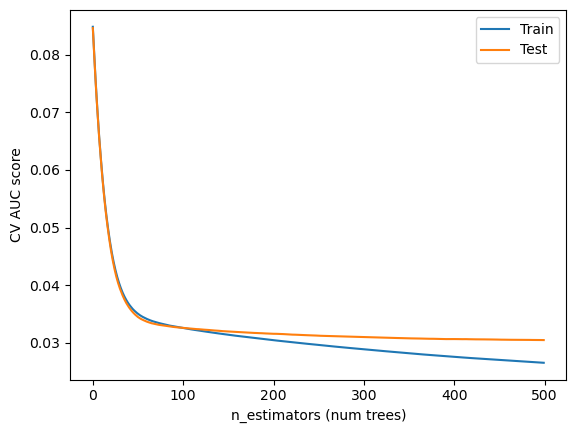

In [103]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [104]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:55:48] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


In [105]:
%%time
pred = model.predict(dtest)

CPU times: user 537 ms, sys: 18.3 ms, total: 555 ms
Wall time: 9.14 ms


In [106]:
np.std(pred-testY)

0.01917179670789813

Text(0.5, 0, 'Prop e')

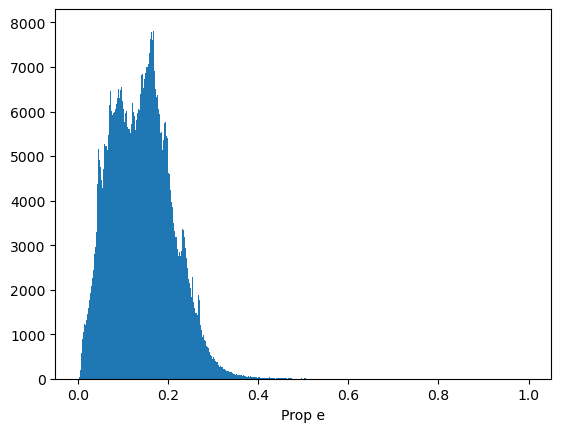

In [107]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(labels['prope'], bins=np.linspace(0, 1, 1000))
ax.set_xlabel('Prop e')

Text(0.5, 0, 'Nesvorny Proper Eccentricity Correction')

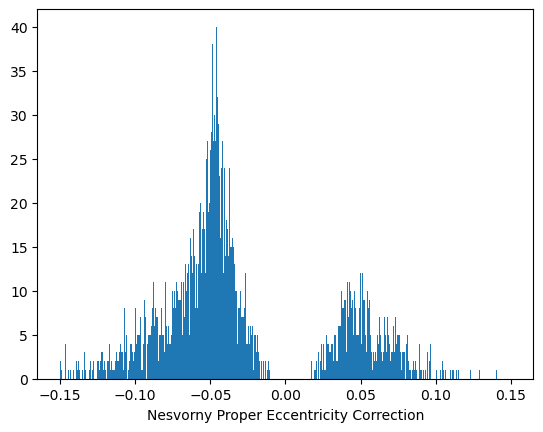

In [108]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Nesvorny Proper Eccentricity Correction')

Text(0.5, 0, 'Correction Error (Model-Nesvorny)')

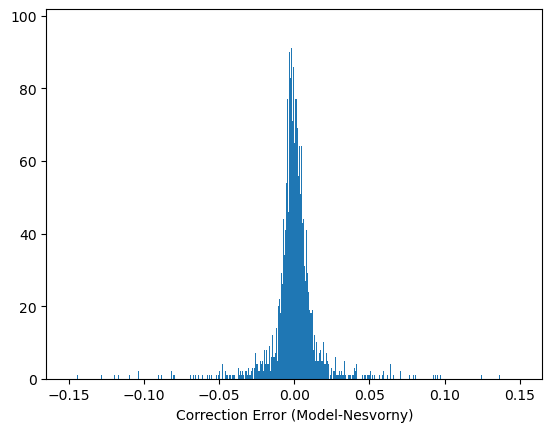

In [109]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')


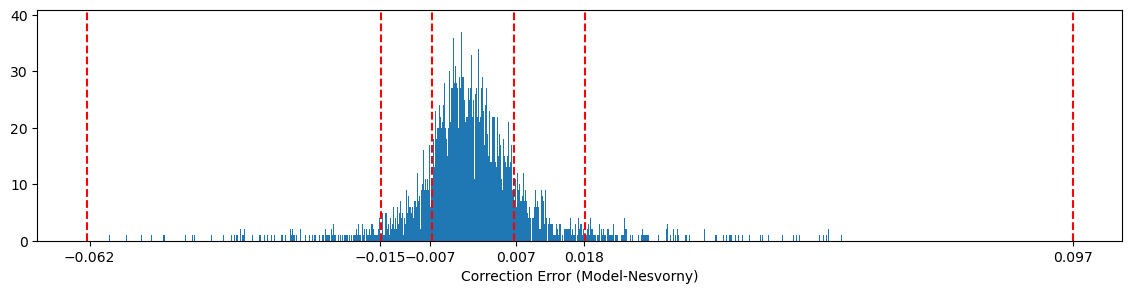

In [79]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

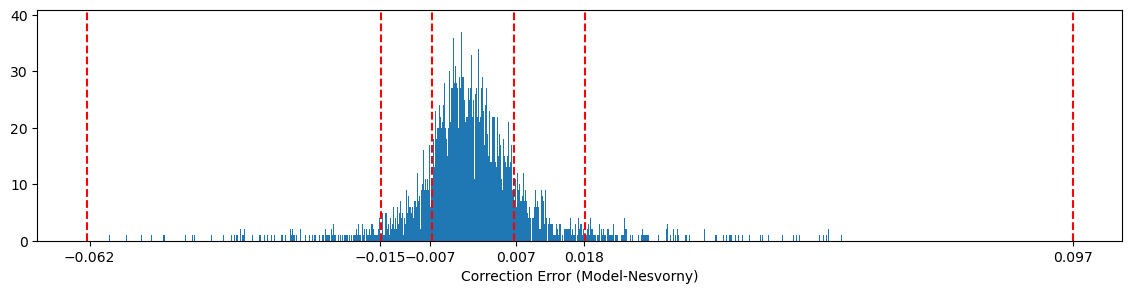

In [80]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

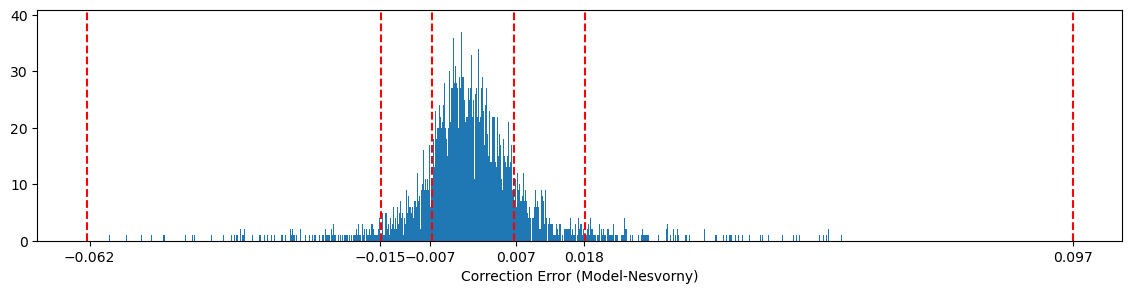

In [81]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

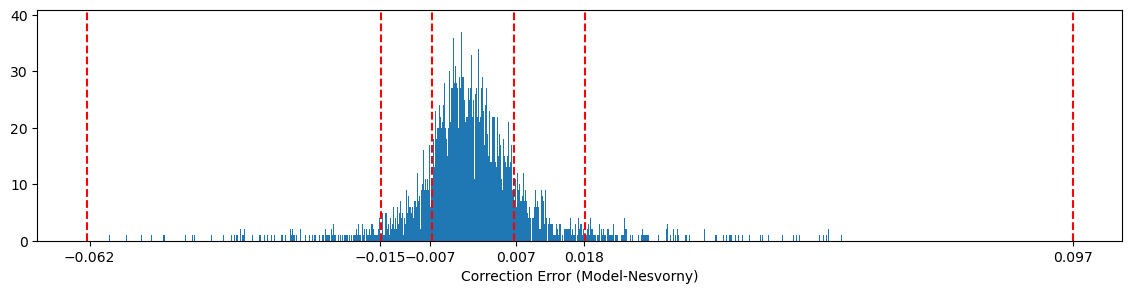

In [82]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

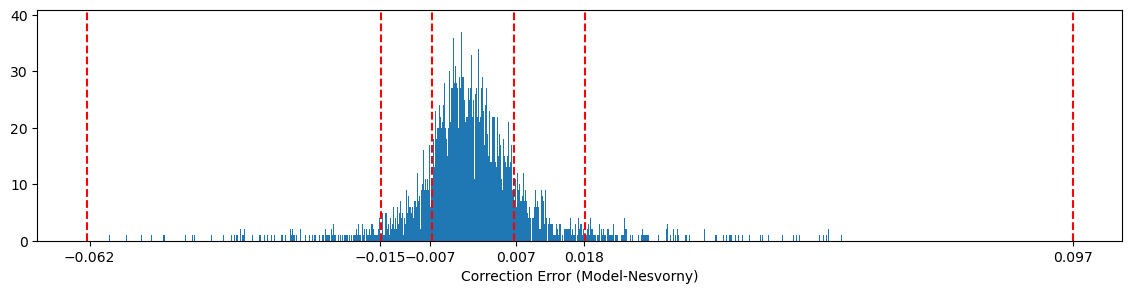

In [83]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

In [84]:
(pred-testY).min()

-0.35988661248505077

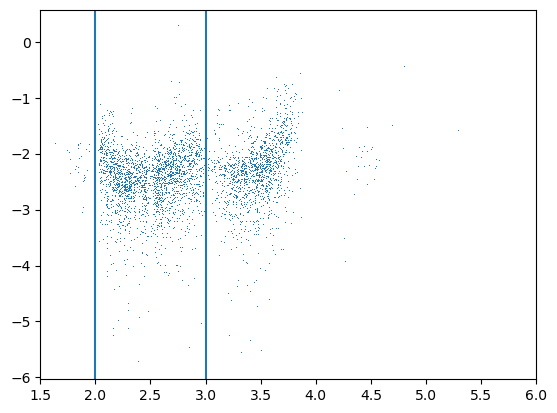

In [85]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

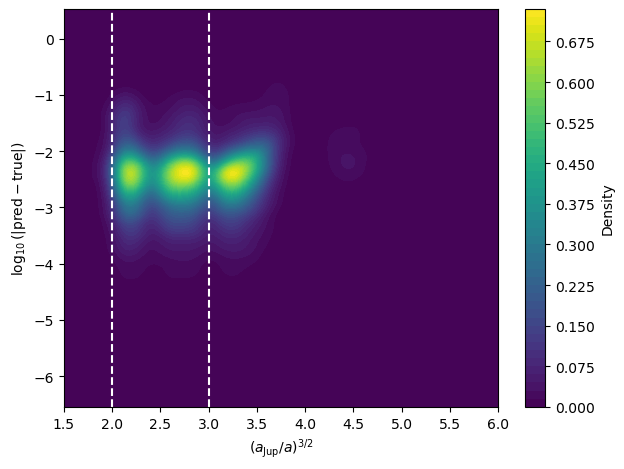

In [40]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()